
# Coffee Vending — EDA Complementario (Notebook Extra)

Este cuaderno **no modifica** el EDA original. Carga los datos *raw*, realiza chequeos de **calidad** y construye un `df_clean` **robusto** para ejecutar análisis **complementarios** (semanal/mensual, Pareto, heatmap hora×producto, revenue acumulado, etc.).


Este EDA amplía el análisis base (días de la semana y productos) para responder preguntas operativas y de calidad de datos. A continuación, el propósito de cada bloque.


## 0. Configuración

In [1]:

from pathlib import Path
RAW_CSV_PATH = Path("../data/raw/index_1.csv")  # ← Ajusta si es necesario


## 1. Imports

In [3]:
from pathlib import Path
import sys

project_root = Path.cwd()  # ajusta si estás en /notebooks
sys.path.append(str(project_root.parent / "utils"))

from coffee_eda_utils import (
    ColumnsConfig, DEFAULT_COLS,
    standardize_types, drop_strict_duplicates, ensure_dt_local, ensure_sorted,
    add_time_features, pick_y_col, pareto_series, calendar_daily_series,
)
COLS = DEFAULT_COLS  # o construye tu ColumnsConfig propio si usas otros nombres


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
sns.set_context("talk")


## 2. Carga de datos RAW y vista rápida

In [5]:

assert RAW_CSV_PATH.exists(), f"No se encontró el CSV en: {RAW_CSV_PATH.resolve()}"
df_raw = pd.read_csv(RAW_CSV_PATH)
print("Shape RAW:", df_raw.shape)
display(df_raw.head())
print("Columnas:", list(df_raw.columns))
print("Nulos:", df_raw.isnull().sum().to_dict())


Shape RAW: (3636, 6)


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


Columnas: ['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name']
Nulos: {'date': 0, 'datetime': 0, 'cash_type': 0, 'card': 89, 'money': 0, 'coffee_name': 0}


## 3. Distribución de montos y outliers


**Por qué:** detectar montos atípicos que pueden ser errores de captura (un cero de más, precios negativos) o casos reales poco frecuentes (combos, promos).
**Qué muestra:** rango típico de transacciones (mediana, IQR), colas largas y valores extremos.
**Decisiones:** definir reglas de limpieza (recortar por percentiles, revisar registros puntuales) y evitar que outliers sesguen promedios y tendencias.
**Cuándo:** antes de limpiar (sobre *raw*).

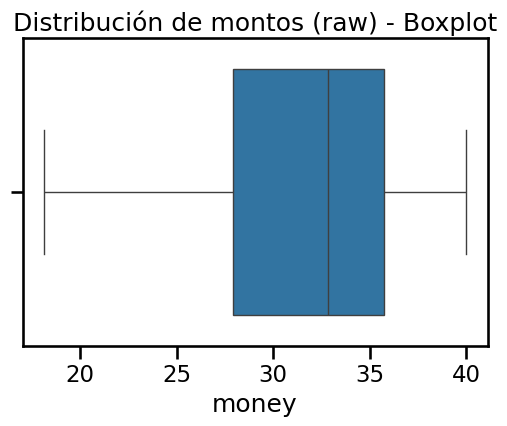

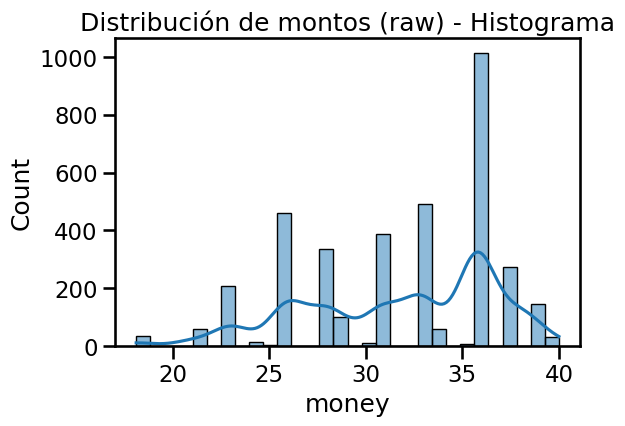

Duplicados exactos en RAW: 0


In [6]:

plt.figure(figsize=(6,4))
sns.boxplot(x=df_raw["money"])
plt.title("Distribución de montos (raw) - Boxplot")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_raw["money"], bins=30, kde=True)
plt.title("Distribución de montos (raw) - Histograma")
plt.show()

print("Duplicados exactos en RAW:", df_raw.duplicated().sum())


## 4. Presencia de productos por día de la semana

**Por qué:** validar cobertura de datos y sesgos; verificar si hay productos ausentes en ciertos días/horas por problemas de carga o por operación real.
**Qué muestra:** matriz de conteos que revela huecos o patrones (ej., un producto nunca aparece los domingos).
**Decisiones:** ajustar procesos de captura, revisar integraciones o planificar surtido/horarios.
**Cuándo:** antes de limpiar (sobre *raw*).

dow,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
coffee_name,,,,,,,
Americano,106,98,71,48,83,83,89
Americano with Milk,105,132,121,103,103,146,114
Cappuccino,65,74,71,71,79,66,75
Cocoa,53,34,25,24,23,58,26
Cortado,37,36,56,44,42,45,32
Espresso,21,12,14,17,27,16,27
Hot Chocolate,45,35,27,40,49,50,36
Latte,112,140,97,87,114,121,111


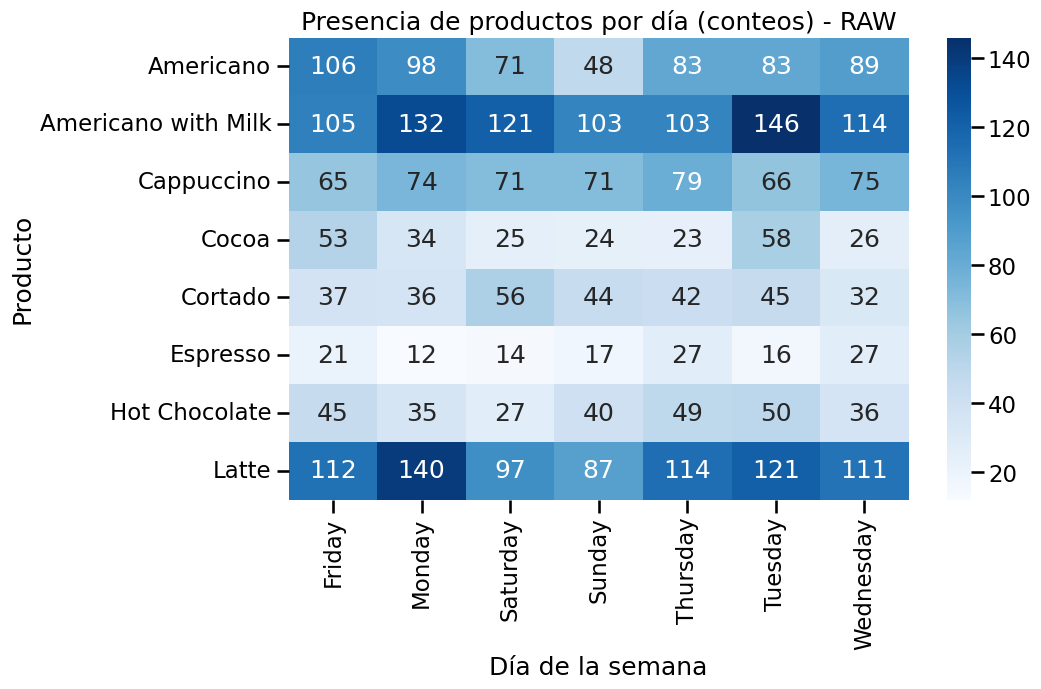

In [7]:

_raw = df_raw.copy()
CANDIDATES = ["datetime", "DateTime", "date_time", "timestamp", "ts", "fecha", "Fecha", "DATE", "Date"]
dt_col = next((c for c in CANDIDATES if c in _raw.columns), None)
if dt_col is None and "date" in _raw.columns:
    _raw["datetime"] = pd.to_datetime(_raw["date"], errors="coerce")
else:
    if dt_col and dt_col != "datetime":
        _raw["datetime"] = pd.to_datetime(_raw[dt_col], errors="coerce")
    elif dt_col == "datetime":
        _raw["datetime"] = pd.to_datetime(_raw["datetime"], errors="coerce")

_raw = _raw[_raw["datetime"].notna()].copy()
_raw["dow"] = _raw["datetime"].dt.day_name()

pivot_presence = pd.pivot_table(
    _raw, values="money", index="coffee_name", columns="dow",
    aggfunc="count", fill_value=0
).sort_index()

display(pivot_presence)

plt.figure(figsize=(10,6))
sns.heatmap(pivot_presence, annot=True, fmt="d", cmap="Blues")
plt.title("Presencia de productos por día (conteos) - RAW")
plt.xlabel("Día de la semana"); plt.ylabel("Producto")
plt.show()


## 5. Construcción robusta de `df_clean`

In [8]:

df_clean = df_raw.copy()
df_clean = standardize_types(df_clean, COLS)

# crea 'datetime' si viniera como 'date'
if COLS.datetime_col not in df_clean.columns and "date" in df_clean.columns:
    df_clean[COLS.datetime_col] = pd.to_datetime(df_clean["date"], errors="coerce")

df_clean = ensure_dt_local(df_clean, dt_col=COLS.datetime_col)  # mantiene el nombre
df_clean = drop_strict_duplicates(df_clean)
df_clean = ensure_sorted(df_clean, COLS)

# limpieza de negocio
if "card" in df_clean.columns:
    df_clean = df_clean.drop(columns=["card"])
df_clean = df_clean[df_clean[COLS.amount_col].notna() & (df_clean[COLS.amount_col] >= 0)]




## 6. Estacionalidad semanal y mensual

**Por qué:** ver tendencias a mayor escala que no se observan en el día a día (fin de mes, estaciones, eventos recurrentes).
**Qué muestra:** evolución del revenue por semana y por mes.
**Decisiones:** planeación de compras y staffing, metas por periodo, detección de meses/semanas atípicas.
**Cuándo:** después de limpiar (sobre *clean*).

C:\Users\Julian\AppData\Local\Temp\ipykernel_2916\1354999287.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = ts["money"].resample("M").sum()


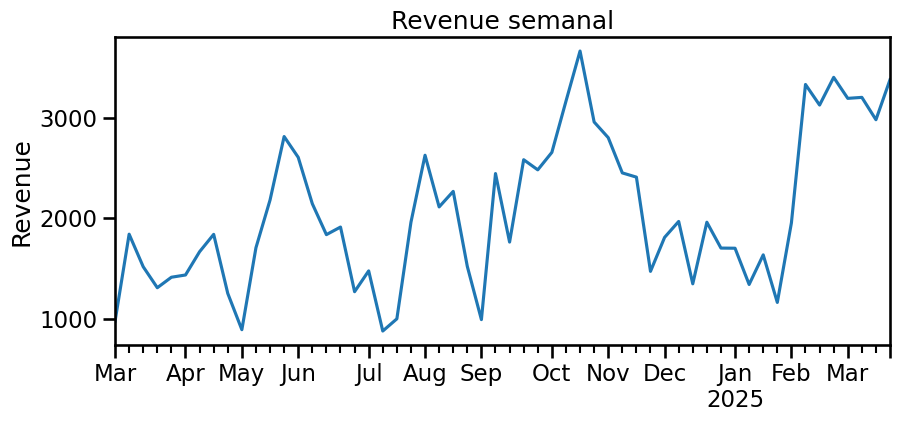

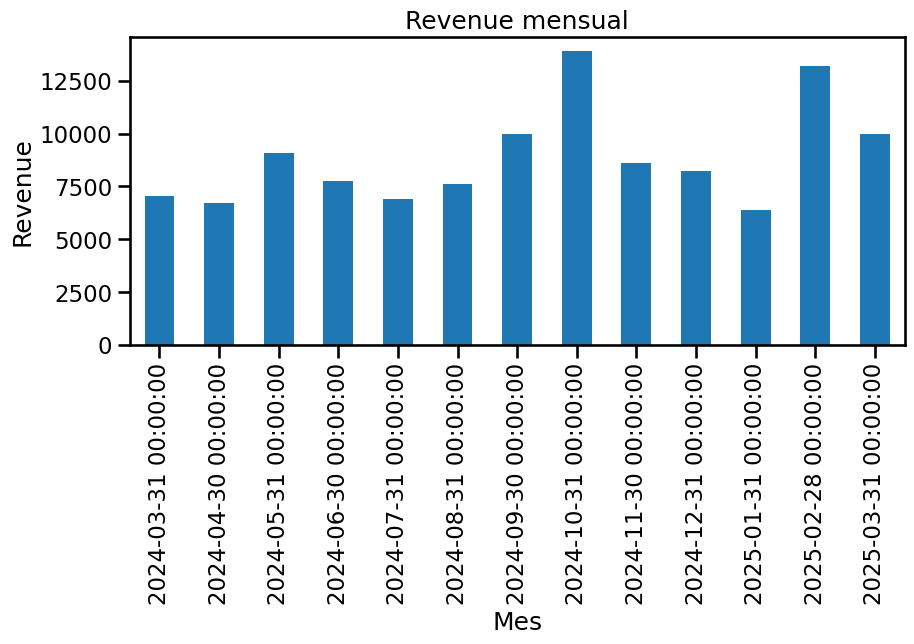

In [9]:

ts = df_clean[["datetime", "money"]].dropna().set_index("datetime").sort_index()

weekly = ts["money"].resample("W").sum()
monthly = ts["money"].resample("M").sum()

ax = weekly.plot(figsize=(10,4), title="Revenue semanal")
ax.set_ylabel("Revenue"); ax.set_xlabel("")
plt.show()

ax = monthly.plot(kind="bar", figsize=(10,4), title="Revenue mensual")
ax.set_ylabel("Revenue"); ax.set_xlabel("Mes")
plt.show()


## 7. Pareto 80/20 por producto

**Por qué:** cuantificar la concentración del revenue en pocos productos.
**Qué muestra:** barras por producto + curva de participación acumulada; permite ver si ~20% de productos explican ~80% del ingreso.
**Decisiones:** priorizar inventario, pricing y promociones en los productos que más mueven la aguja.
**Cuándo:** después de limpiar (sobre *clean*).

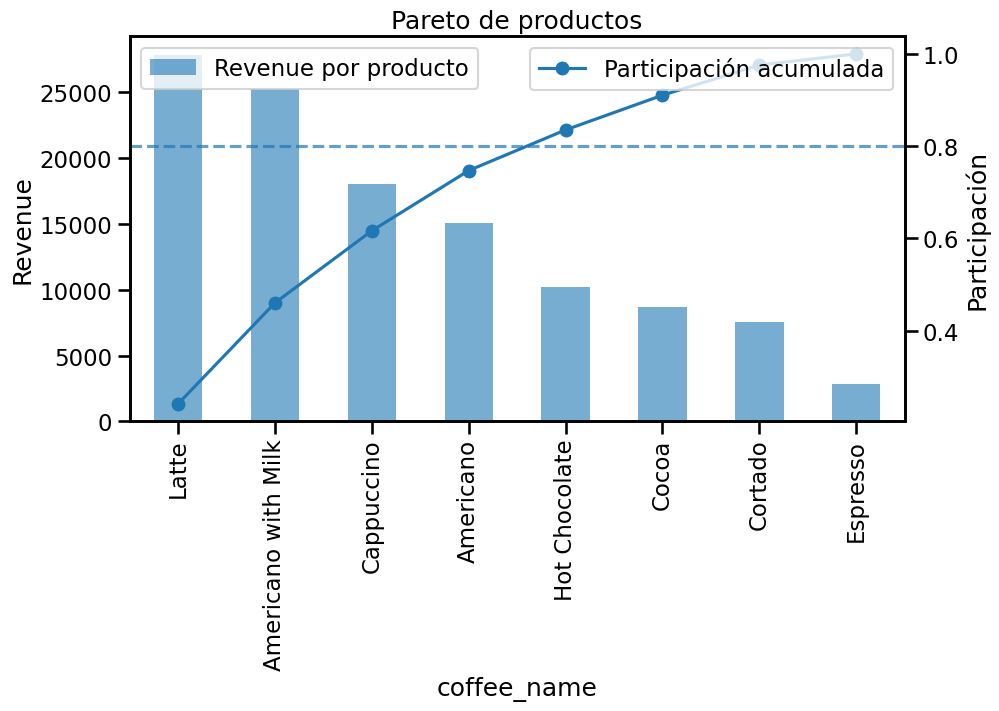

In [10]:

prod_rev = df_clean.groupby("coffee_name")["money"].sum().sort_values(ascending=False)
cum_share = prod_rev.cumsum() / prod_rev.sum()

fig, ax1 = plt.subplots(figsize=(10,5))
prod_rev.plot(kind="bar", ax=ax1, alpha=0.6, label="Revenue por producto")
ax1.set_ylabel("Revenue"); ax1.set_title("Pareto de productos")

ax2 = ax1.twinx()
cum_share.plot(ax=ax2, marker="o", label="Participación acumulada")
ax2.axhline(0.8, linestyle="--", alpha=0.7)
ax2.set_ylabel("Participación")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.show()


## 8. Heatmap hora × producto

**Por qué:** entender el mix por franja horaria (qué se vende en la mañana vs. tarde).
**Qué muestra:** intensidad de ingresos por producto a cada hora.
**Decisiones:** surtido por franja, empaques “listos” y asignación de personal en horas pico.
**Cuándo:** después de limpiar (sobre *clean*).

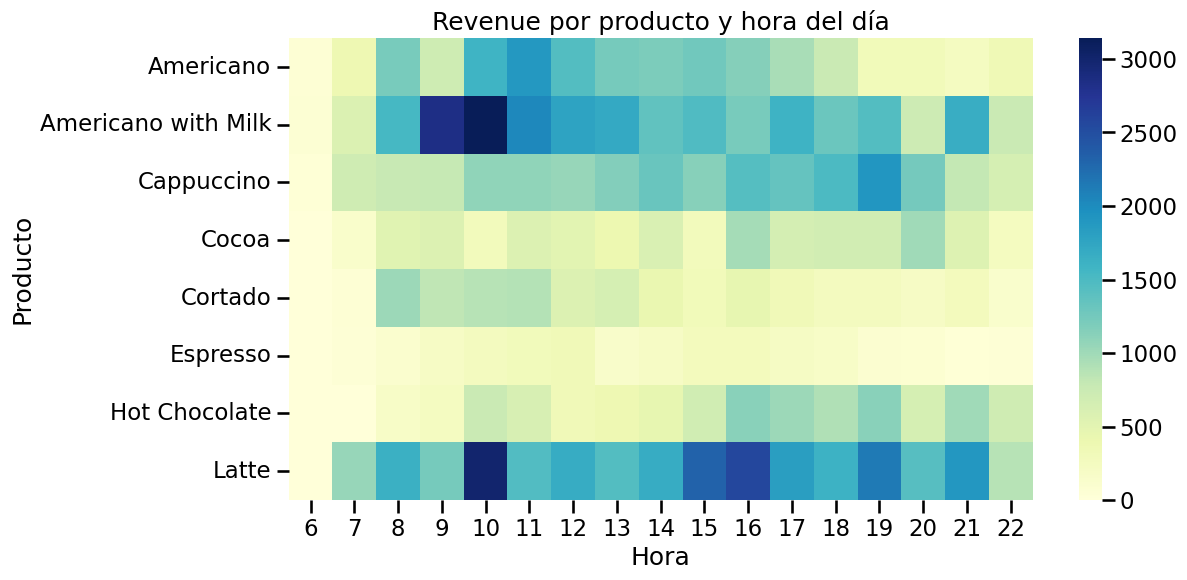

In [11]:

_df = df_clean.copy()
_df["hour"] = _df["datetime"].dt.hour

pivot_hp = pd.pivot_table(
    _df, values="money", index="coffee_name", columns="hour",
    aggfunc="sum", fill_value=0
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_hp, cmap="YlGnBu")
plt.title("Revenue por producto y hora del día")
plt.xlabel("Hora"); plt.ylabel("Producto")
plt.show()


## 9. Revenue acumulado

**Por qué:** visualizar la progresión de ventas y cambios de pendiente.
**Qué muestra:** curva acumulada; saltos o quiebres sugieren promos, fallos operativos o cambios de demanda.
**Decisiones:** monitoreo macro, evaluación de efectos de campañas o incidencias.
**Cuándo:** después de limpiar (sobre *clean*).

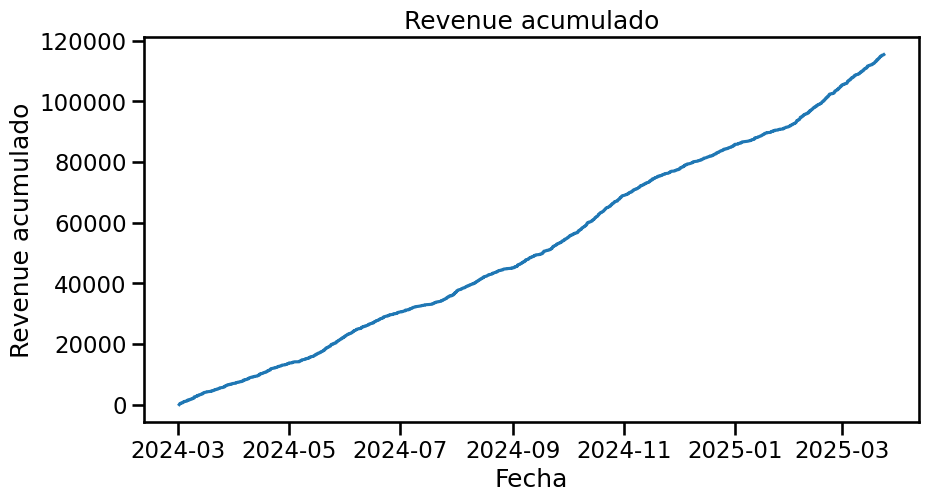

In [12]:

_df = df_clean.sort_values("datetime").copy()
_df["cumulative_revenue"] = _df["money"].cumsum()

plt.figure(figsize=(10,5))
plt.plot(_df["datetime"], _df["cumulative_revenue"])
plt.title("Revenue acumulado")
plt.xlabel("Fecha"); plt.ylabel("Revenue acumulado")
plt.show()


## 10. Calendar plot

**Por qué:** detectar patrones por fechas específicas (festivos, eventos locales) en formato calendario.
**Qué muestra:** intensidad diaria por año/mes en un vistazo.
**Decisiones:** planificar campañas y turnos alrededor de días “calientes” o fríos.
**Cuándo:** después de limpiar (sobre *clean*).

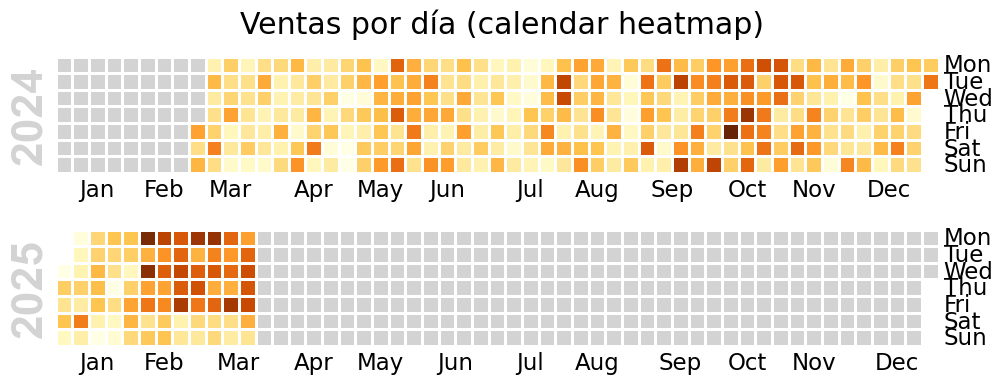

In [14]:
# !pip install calmap
import numpy as np
import matplotlib.pyplot as plt
import calmap

s_daily = calendar_daily_series(df_clean, COLS)  # DatetimeIndex diario

fig, axes = calmap.calendarplot(
    s_daily,
    cmap="YlOrBr",
    fillcolor="lightgray",
    fig_kws={"figsize": (14, 4)}
)

fig.suptitle("Ventas por día (calendar heatmap)", y=0.98)  # título global
plt.show()
